In [1]:
import sys
sys.path.insert(0,'/home/ernie/caffe2/build')
from caffe2.python import cnn,workspace,core
from caffe2.proto import caffe2_pb2
import numpy as np
import time

In [2]:
mbox_loc = np.load('mbox_loc.npy')
mbox_conf = np.load('mbox_conf.npy')
mbox_priorbox = np.load('mbox_priorbox.npy')
gt_label = np.load('gt_label.npy')

net = core.Net("mboxloss_test")
net.MultiboxLoss(["loc","conf","prior","gt_label"],["loc_pred","loc_gt","conf_pred","conf_gt"])
net.SmoothL1Loss(["loc_pred","loc_gt"],["smooth_loss"])
net.SoftmaxWithLoss(["conf_pred","conf_gt"],["P","softmax_loss"])
net.AddGradientOperators(["smooth_loss","softmax_loss"])
#net.AddGradientOperators()

{BlobReference("loc_pred"): BlobReference("loc_pred_grad"),
 BlobReference("conf"): BlobReference("conf_grad"),
 BlobReference("softmax_loss"): BlobReference("softmax_loss_autogen_grad"),
 BlobReference("conf_pred"): BlobReference("conf_pred_grad"),
 BlobReference("smooth_loss"): BlobReference("smooth_loss_autogen_grad"),
 BlobReference("loc"): BlobReference("loc_grad")}

In [3]:
workspace.FeedBlob("loc",mbox_loc)
workspace.FeedBlob("conf",mbox_conf)
workspace.FeedBlob("prior",mbox_priorbox)
workspace.FeedBlob("gt_label",gt_label)

workspace.CreateNet(net.Proto())
workspace.RunNet('mboxloss_test',1)

dloc = workspace.FetchBlob('loc_grad')
dconf = workspace.FetchBlob('conf_grad')

In [4]:
print np.shape(dloc)
print np.shape(dconf)

(1, 34928)
(1, 183372)


In [5]:
np.set_printoptions(threshold=np.NaN)
ddloc = np.load('dloc.npy')
ddconf = np.load('dconf.npy')
print np.sum(dloc-ddloc)
d = dconf - ddconf
print d[d!=0]

0.0
[  2.32830644e-10  -6.98491931e-10  -9.31322575e-10   4.65661287e-10
  -9.31322575e-10   2.32830644e-10  -1.16415322e-10   9.31322575e-10
  -4.65661287e-10  -4.65661287e-10  -2.32830644e-10  -2.32830644e-10
  -1.86264515e-09   1.86264515e-09   2.91038305e-10   4.65661287e-10
  -2.32830644e-10  -2.32830644e-10  -4.65661287e-10   1.16415322e-10
   1.74622983e-10  -1.86264515e-09  -2.32830644e-10   2.32830644e-10
   2.32830644e-10   9.31322575e-10  -2.32830644e-10   2.32830644e-10
  -1.16415322e-10  -4.65661287e-10   1.74622983e-10   3.49245965e-10
  -1.16415322e-10   4.65661287e-10   2.32830644e-10  -9.31322575e-10
   2.32830644e-10  -1.16415322e-10   1.16415322e-10   1.86264515e-09
   3.49245965e-10   5.82076609e-11   2.79396772e-09   1.16415322e-10
   1.16415322e-10  -4.65661287e-10   2.32830644e-10   2.32830644e-10
   4.65661287e-10   4.65661287e-10   2.32830644e-10  -4.65661287e-10
   4.65661287e-10  -1.16415322e-10  -1.39698386e-09   2.32830644e-10
   9.31322575e-10  -1.16415322

In [6]:
print net.Proto()

name: "mboxloss_test"
op {
  input: "loc"
  input: "conf"
  input: "prior"
  input: "gt_label"
  output: "loc_pred"
  output: "loc_gt"
  output: "conf_pred"
  output: "conf_gt"
  name: ""
  type: "MultiboxLoss"
}
op {
  input: "loc_pred"
  input: "loc_gt"
  output: "smooth_loss"
  name: ""
  type: "SmoothL1Loss"
}
op {
  input: "conf_pred"
  input: "conf_gt"
  output: "P"
  output: "softmax_loss"
  name: ""
  type: "SoftmaxWithLoss"
}
op {
  input: "softmax_loss"
  output: "softmax_loss_autogen_grad"
  name: ""
  type: "ConstantFill"
  arg {
    name: "value"
    f: 1.0
  }
}
op {
  input: "smooth_loss"
  output: "smooth_loss_autogen_grad"
  name: ""
  type: "ConstantFill"
  arg {
    name: "value"
    f: 1.0
  }
}
op {
  input: "conf_pred"
  input: "conf_gt"
  input: "P"
  input: "softmax_loss_autogen_grad"
  output: "conf_pred_grad"
  name: ""
  type: "SoftmaxWithLossGradient"
  is_gradient_op: true
}
op {
  input: "loc_pred"
  input: "loc_gt"
  input: "smooth_loss_autogen_grad"
  ou

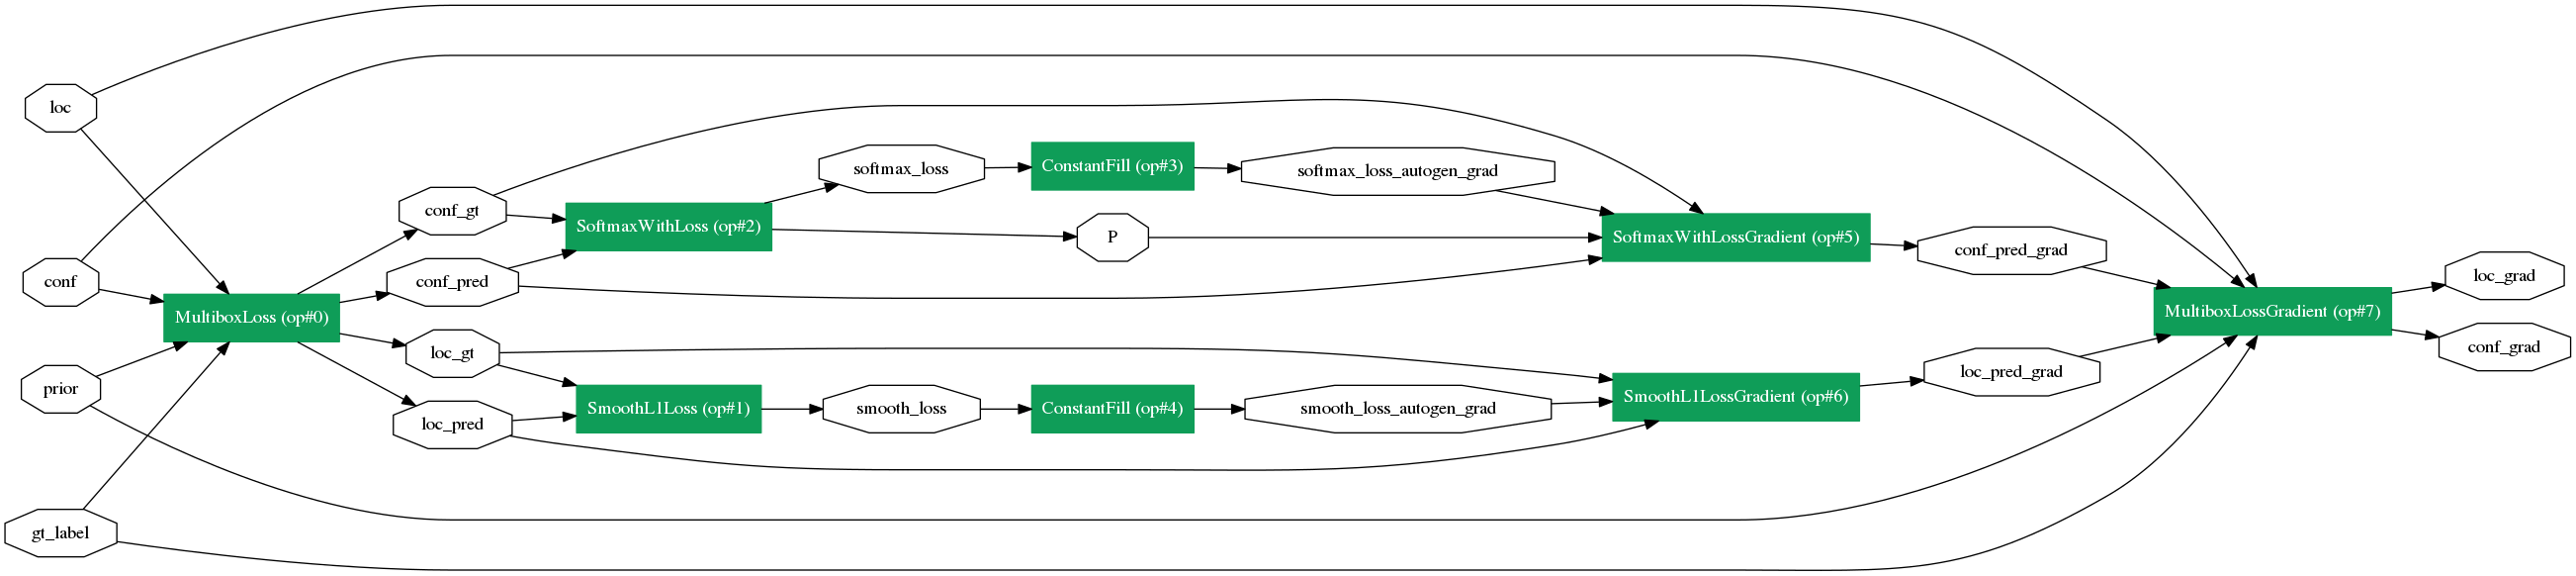

In [8]:
from IPython import display
from caffe2.python import net_drawer
graph = net_drawer.GetPydotGraph(net.Proto().op, "multiboxtest", rankdir="LR")
display.Image(graph.create_png(), width=800)

In [8]:
smoothloss = workspace.FetchBlob('smooth_loss_autogen_grad')
print smoothloss

1.0
